In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import string

import numpy as np

import pandas as pd

from joblib import Parallel, delayed
from tqdm import tqdm

from rdmc.mol import RDKitMol
from rdkit.Chem.Descriptors import ExactMolWt, NumRadicalElectrons
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumHBD, CalcNumHeavyAtoms, CalcNumRotatableBonds
from rdkit.Chem import GetPeriodicTable

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from rmgpy.molecule import Molecule
from rmgpy.data.thermo import ThermoDatabase, ThermoGroups, ThermoData


from tree.parameters import Ts, columns

In [2]:
HBI_correction_df = pd.read_csv("../data/hbi_unc.csv")
HBI_correction_df

,radical_smiles,resonance_radical_smiles,resonance_radical_num_rotatable_bonds,radical_H298 (kcal/mol),radical_Sint298 (cal/mol/K),radical_source,radical_level_of_theory,radical_Cp300 (cal/mol/K),radical_Cp400 (cal/mol/K),radical_Cp500 (cal/mol/K),...,unc_closed_shell_Cp1500 (cal/mol/K),unc_HBI_H298 (kcal/mol),unc_HBI_Sint298 (cal/mol/K),unc_HBI_Cp300 (cal/mol/K),unc_HBI_Cp400 (cal/mol/K),unc_HBI_Cp500 (cal/mol/K),unc_HBI_Cp600 (cal/mol/K),unc_HBI_Cp800 (cal/mol/K),unc_HBI_Cp1000 (cal/mol/K),unc_HBI_Cp1500 (cal/mol/K)
0,[O]C(=O)OC(O)(O)O,[O]C(=O)OC(O)(O)O,4,-223.514126,95.999974,dong_pio_liang.py,CBS-QB3,33.926878,38.387673,41.508496,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
1,[O]C(O)(O)OC(=O)O,[O]C(O)(O)OC(=O)O,3,-223.423390,92.781436,dong_pio_liang.py,CBS-QB3,32.531179,37.569659,41.498443,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
2,O=C(O)O[C](O)O,O=C(O)O[C](O)O,3,-187.322869,89.517068,dong_pio_liang.py,CBS-QB3,28.973242,34.553073,38.746721,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
3,CC(=O)OC(OO)C(=O)C(O)O[O],CC(=O)OC(OO)C(=O)C(O)O[O],8,-185.660577,132.633380,dong_pio_liang.py,CBS-QB3,56.569703,66.028226,73.603744,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
4,O=[C]OC(O)(O)O,O=[C]OC(O)(O)O,5,-180.497563,90.031975,dong_pio_liang.py,CBS-QB3,32.378191,36.844343,39.334179,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2800,C1=C[CH]C=1,[C]1=CC=C1,0,156.106582,65.385768,dong_pio_liang.py,CBS-QB3,14.653111,18.488757,21.562144,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
2801,C=C=C1C=[C]C1,C=C=C1C=[C]C1,0,157.733085,77.587625,dong_pio_liang.py,CBS-QB3,22.675255,28.333884,32.976246,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
2802,[CH2]C1=CC#CC1,[CH2]C1=CC#CC1,1,163.498344,75.963844,dong_pio_liang.py,CBS-QB3,22.606638,28.495118,33.391100,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068
2803,[CH2]C1=CC#CC1,C=C1[CH]C#CC1,0,163.498344,75.963844,dong_pio_liang.py,CBS-QB3,22.606638,28.495118,33.391100,...,2.0,4.176123,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068,2.236068


# Plot HBI distribution

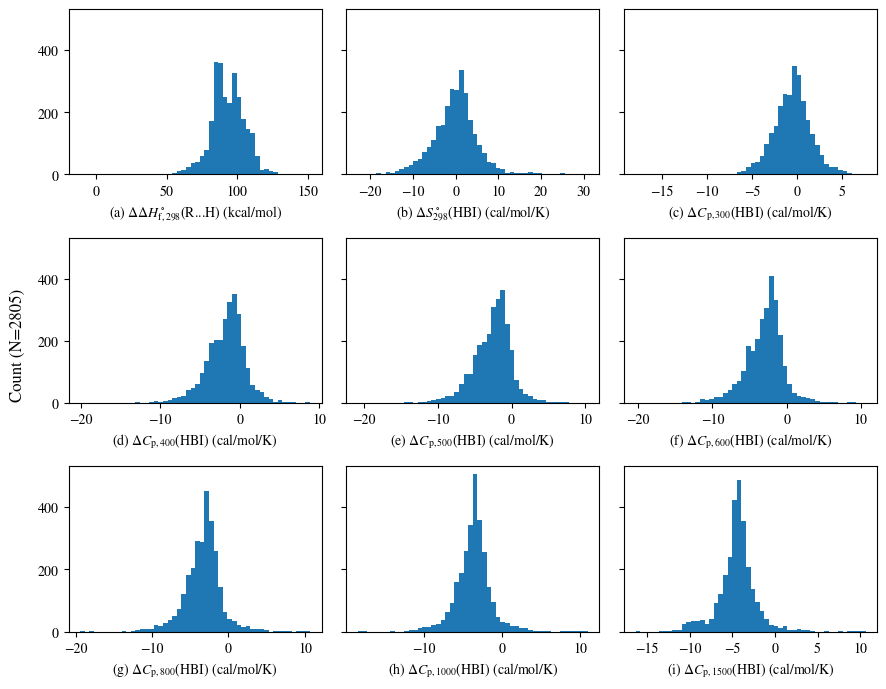

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
ax.hist(HBI_correction_df["HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(HBI_correction_df["HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(HBI_correction_df[f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(HBI_correction_df.index)})')
fig.tight_layout()
fig.savefig("../figures/data_hbi_hist.pdf", bbox_inches="tight")

# Plot all HBI corrections in empirical tree

In [4]:
thermo_database = ThermoDatabase()
empirical_tree = ThermoGroups().load("/home/gridsan/hwpang/Software/RMG-database/input/thermo/groups/radical.py", thermo_database.local_context, thermo_database.global_context)
print(len(empirical_tree.entries.keys()))
print(sum([1 for entry in empirical_tree.entries.values() if isinstance(entry.data, ThermoData)]))

1994
1828


In [5]:
print(sum([1 for entry in empirical_tree.entries.values() if isinstance(entry.data, ThermoData) and entry.data.H298.uncertainty_si!=0.0]))


1580


In [6]:
print(sum([1 for label in empirical_tree.entries.keys() if "Br" in label or "Cl" in label or "F" in label]))


1473


In [7]:
temp_dict = {
    "label": [],
    "HBI_H298 (kcal/mol)": [],
}

for column in columns[2:]:
    temp_dict["HBI_"+column] = []
for label, entry in empirical_tree.entries.items():
    if isinstance(entry.data, ThermoData):
        temp_dict["label"].append(label)
        temp_dict["HBI_H298 (kcal/mol)"].append(entry.data.H298.value_si/4184)
        temp_dict["HBI_Sint298 (cal/mol/K)"].append(entry.data.S298.value_si/4.184)
        for i, T in enumerate(Ts):
            temp_dict[f"HBI_Cp{T} (cal/mol/K)"].append(entry.data.Cpdata.value_si[i]/4.184)
            
empirical_hbi_df = pd.DataFrame(temp_dict)

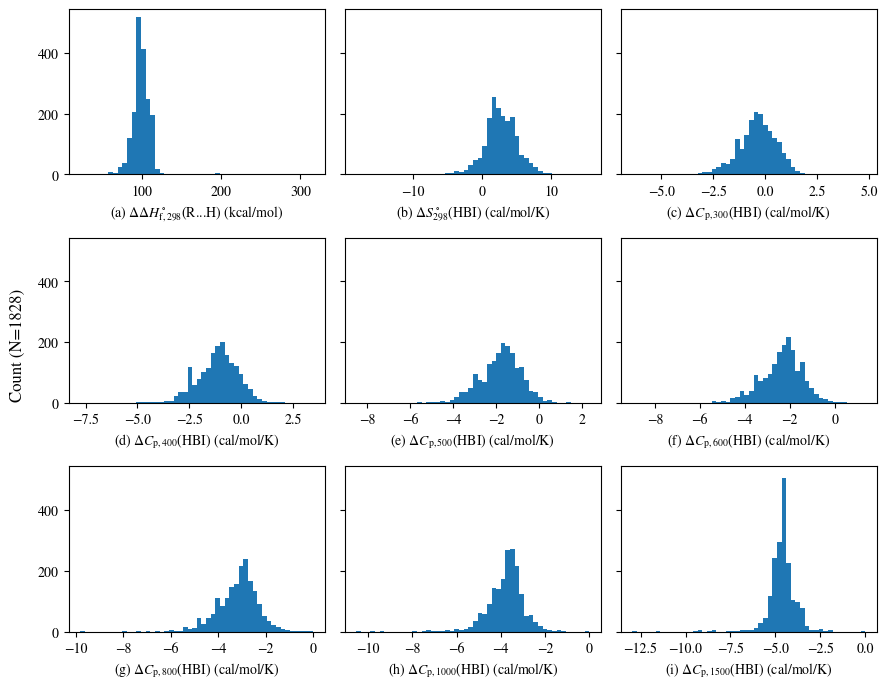

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))
ax = axs.flat[0]
ax.hist(empirical_hbi_df["HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(empirical_hbi_df["HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(empirical_hbi_df[f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(empirical_hbi_df.index)})')
fig.tight_layout()
fig.savefig("../figures/empirical_hbi_hist.pdf", bbox_inches="tight")

# Analyze outliers

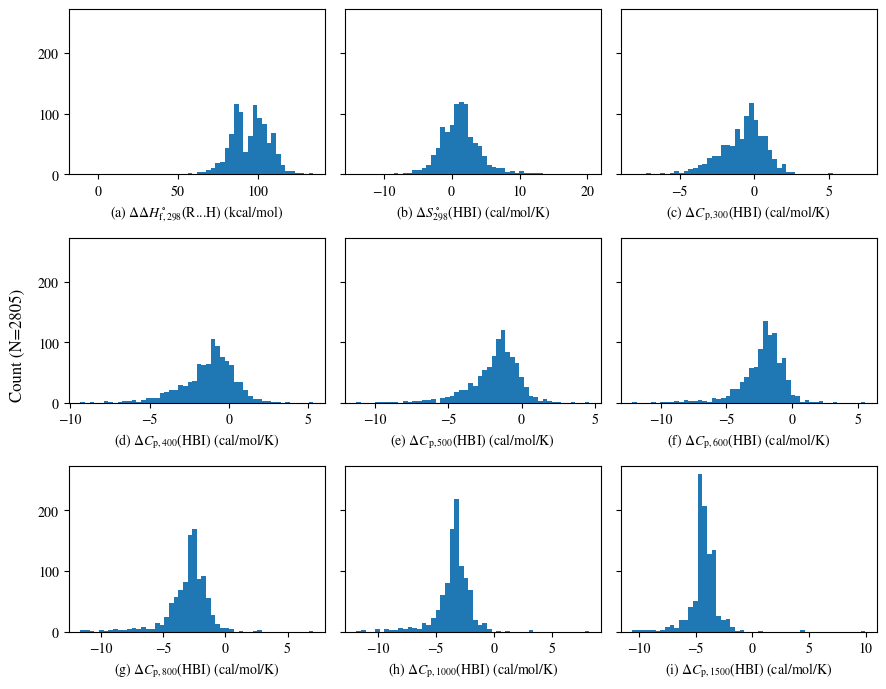

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 7))

query = HBI_correction_df['closed_shell_thermo_source'] != "GAV"
ax = axs.flat[0]
ax.hist(HBI_correction_df.loc[query, "HBI_H298 (kcal/mol)"], bins=50)
ax.set_xlabel("(a) $\Delta \Delta H^\circ_\mathrm{f,298}$(R...H) (kcal/mol)")

ax = axs.flat[1]
ax.hist(HBI_correction_df.loc[query, "HBI_Sint298 (cal/mol/K)"], bins=50)
ax.set_xlabel("(b) $\Delta S^\circ_\mathrm{298}$(HBI) (cal/mol/K)")

for ax, T, alph in zip(axs.flat[2:], Ts, list(string.ascii_lowercase)[2:]):
    ax.hist(HBI_correction_df.loc[query, f"HBI_Cp{T} (cal/mol/K)"], bins=50)
    ax.set_xlabel(f"({alph}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$(HBI) (cal/mol/K)")

fig.supylabel(f'Count (N={len(HBI_correction_df.index)})')
fig.tight_layout()